# Multi-modal

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-deepmind/gemma/blob/main/colabs/multimodal.ipynb)

Example on how to use Gemma models for multi-modal.

In [ ]:
!pip install -q gemma

In [ ]:
# Common imports
import os
import jax.numpy as jnp
import tensorflow_datasets as tfds

# Gemma imports
from gemma import gm

By default, Jax do not utilize the full GPU memory, but this can be overwritten. See [GPU memory allocation](https://docs.jax.dev/en/latest/gpu_memory_allocation.html):

In [ ]:
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

First, let's load an image:

array([[[1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [7, 7, 5],
        [6, 6, 4],
        [5, 5, 3]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [7, 7, 5],
        [6, 6, 4],
        [5, 5, 3]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [7, 7, 5],
        [6, 6, 4],
        [5, 5, 3]]], shape=(500, 667, 3), dtype=uint8)
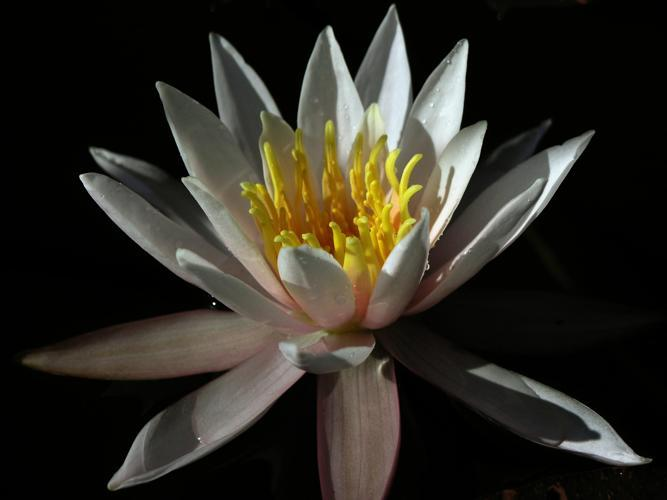

In [ ]:
ds = tfds.data_source('oxford_flowers102', split='train')
image = ds[0]['image']
image

Load the model and params.

In [ ]:
model = gm.nn.Gemma3_4B()

params = gm.ckpts.load_params(gm.ckpts.CheckpointPath.GEMMA3_4B_IT)

## Sampling full prompt

To use the multi-modal capabilities, simply:

* In the prompt: Add the `<start_of_image>` special tokens, where the images should be inserted.
* Pass the image(s) to the `images=` argument of the sampler

In [ ]:
sampler = gm.text.ChatSampler(
    model=model,
    params=params,
)

out = sampler.chat(
    'What can you say about this image: <start_of_image>',
    images=image,
)
print(out)

Here's a breakdown of what I can say about the image:

**Overall Impression:**

The image is a stunning, close-up photograph of a water lily in full bloom. It’s dramatically lit, creating a strong contrast between light and shadow, which really emphasizes the flower's form and texture.

**Specific Details:**

*   **Flower Type:** It appears to be a Nymphaea (water lily). The shape of the petals and the prominent stamens are characteristic of this type of flower.
*   **Color:** The petals are primarily white with a subtle pinkish hue at the base. The stamens are a bright, vibrant yellow.
*   **Lighting:** The lighting is key. There's a strong light source coming from the upper left, casting dramatic shadows and highlighting the edges of the petals. This creates a sense of depth and makes the flower appear almost sculptural.
*   **Texture:** You can see the delicate texture of the petals – they appear smooth but with subtle ridges and folds.
*   **Composition:** The flower is centered in

Notes:

* The model was trained on `jpeg` images. If you have PNG images, those should be encoded/decoded to Jpeg, to avoid bias.

* You can pass multiple images. Just add `<start_of_image>` everywhere an image should be inserted. All images should be resized to the same shape. Input shape would then be `batch, num_images, h, w, c` (instead of `batch, h, w, c`).

* If prompts within a batch have different number of images, just pad the tensor with 0 (or any) values for unused images.

## Calling model directly

Adding images to the model only require to:

* In the prompt: Add `<start_of_image>` special tokens where the images should be inserted.

In [8]:
tokenizer = gm.text.Gemma3Tokenizer()


prompt = """<start_of_turn>user
Describe this image in a single word.

<start_of_image>

<end_of_turn>
<start_of_turn>model
"""
prompt = jnp.asarray(tokenizer.encode(prompt, add_bos=True))

* In the model: pass the `images=` to `model.apply`.

In [ ]:
# Run the model
out = model.apply(
    {'params': params},
    tokens=prompt,
    images=image,
    return_last_only=True,  # Only predict the last token
)


# Plot the probability distribution
tokenizer.plot_logits(out.logits)

## Finetuning

Finetuning with multi-modal is also simple. From the original [finetuning](https://gemma-llm.readthedocs.io/en/latest/finetuning.html), changing to multi-modal only require 2 changes:

* Have a dataset which also return an image (`b h w c`), or multiple images (`b n h w c`)
* Specify the model input which field in the batch correspond to the images:

  ```python
  model = gm.nn.Gemma3_4B(
      tokens='batch.tokens',
      images='batch.image',
  )
  ```

See the [`multimodal.py`](https://github.com/google-deepmind/gemma/tree/main/examples/multimodal.py) example.